# Whisper Implementation

In this notebook we will implement a Encoder + Classification Head structure. The idea is to extract the encoder's hidden states and then feed them to a linear classification layer that, hopefully, will give us the correct label.

In [1]:
import torch
import librosa
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict, Audio
import evaluate
from transformers import WhisperFeatureExtractor, WhisperModel, Trainer, TrainingArguments
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import json

SEED = 2706

c:\Users\faler\anaconda3\envs\tfm_audio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


After loading the modules we will need, we prepare the data to be preprocessed. In order to get comparable results with the other models, we have to leave out 'Calm' and 'Surprise' emotions. Besides, since we are going to do data augmentation and use a Hugging Face model, we have to prepare a datasets' Dataset, as well as splitting it beforehand.

In [2]:
# ==========================
# Inicial config
# ==========================
MODEL_ID = "openai/whisper-large-v3-turbo"
CSV_PATH = "./audio_data/complete_metadata.csv"   # Paths & labels
AUDIO_COL = "Path"
LABEL_COL = "Emotion"

sr = 16000 # Required for the trained Whisper model

audios = pd.read_csv(CSV_PATH)
audios = audios[~((audios[LABEL_COL] == 'Calm') | (audios[LABEL_COL] == 'Surprised'))]
audios = audios.rename(mapper={'Path': 'file', 'Emotion':'labels'}, axis=1).drop(columns=['Dataset', 'Sex', 'Emotional_level'])

dataset = Dataset.from_pandas(audios)
dataset = dataset.train_test_split(test_size=0.25, seed=SEED)

In [3]:
# ==========================
# Whisper Encoder
# ==========================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_ID)
whisper_model = WhisperModel.from_pretrained(MODEL_ID).to(device)

cuda


## Data extraction

Now we face the task of extracting the embeddings from the encoder. To get enough data for the classification head, we will perform 2 augmentations for each original row. We have to be careful here also to not induce any data leakage. Thus, we divide the preprocessing into two cases: train or test split. The way we preprocess the data itself is the same, but in the train function there is included a code to augment data.

In [4]:
# ============
# Augmentations
# ============
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
])

# ============
# Embedding extractor (batch)
# ============
def extract_embeddings_batch(waveforms: list[np.ndarray], sr: int) -> np.ndarray:
    """
    Extract embeddings for a batch of audio waveforms using a Whisper encoder.

    Each waveform is transformed into log-Mel spectrogram features, padded
    or trimmed to the expected input length for Whisper, and then passed
    through the encoder to produce embeddings.

    Args:
        waveforms: List of audio signals as NumPy arrays.
        sr: Sampling rate of the input signals.

    Returns:
        np.ndarray: Batch of embeddings with shape [batch_size, embedding_dim].
    """
    # Convert waveforms into Whisper log-Mel features
    inputs = feature_extractor(
        waveforms,
        sampling_rate=sr,
        return_tensors="pt"
    ).to(device)

    feats = inputs.input_features  # Shape: [B, n_mels, T]
    B, n_mels, T = feats.shape

    # Adjust sequence length to Whisper's expected size (3000 frames)
    if T < 3000:
        pad_size = 3000 - T
        feats = F.pad(feats, (0, pad_size), mode="constant", value=0.0)
    elif T > 3000:
        feats = feats[:, :, :3000]

    # Extract embeddings using the encoder
    with torch.no_grad():
        encoder_outputs = whisper_model.encoder(feats)
        hidden_states = encoder_outputs.last_hidden_state  # [B, T, D]

        # Mean-pool across the time dimension
        embeddings = hidden_states.mean(dim=1)  # [B, D]

    return embeddings.cpu().numpy()

# ============
# Train preprocessing
# ============
def preprocess_train(batch: dict, n_augment: int = 2) -> dict:
    """
    Preprocess a batch of audio files for training.

    For each audio file in the batch:
        - Load waveform at the target sampling rate.
        - Apply augmentation `n_augment` times.
        - Collect augmented waveforms and labels.
    Finally, embeddings are extracted for the augmented waveforms.

    Args:
        batch: Dictionary with keys:
            - "file": List of file paths to audio files.
            - "labels": List of corresponding labels.
        n_augment: Number of augmentations to generate per file (default is 2).

    Returns:
        dict: Dictionary with keys:
            - "embedding": NumPy array of embeddings for augmented waveforms.
            - "labels": List of labels matching the augmented waveforms.
    """
    waveforms = []
    labels = []

    for file, label in zip(batch["file"], batch["labels"]):
        # Load audio at target sampling rate
        waveform, _ = librosa.load(file, sr=sr)

        # Apply augmentations multiple times
        for _ in range(n_augment):
            aug_waveform = augment(samples=waveform, sample_rate=sr).astype(np.float32)
            waveforms.append(aug_waveform)
            labels.append(label)

    # Extract embeddings for augmented waveforms
    embeddings = extract_embeddings_batch(waveforms, sr)

    return {"embedding": embeddings, "labels": labels}

# ============
# Eval preprocessing
# ============
def preprocess_eval(batch: dict) -> dict:
    """
    Preprocess a batch of audio files for evaluation.

    For each audio file in the batch:
        - Load waveform at the target sampling rate.
        - Collect waveforms and labels.
    Finally, embeddings are extracted for the waveforms.

    Args:
        batch: Dictionary with keys:
            - "file": List of file paths to audio files.
            - "labels": List of corresponding labels.

    Returns:
        dict: Dictionary with keys:
            - "embedding": NumPy array of embeddings for the waveforms.
            - "labels": List of labels corresponding to the waveforms.
    """
    waveforms = []
    labels = []

    for file, label in zip(batch["file"], batch["labels"]):
        # Load audio at target sampling rate
        waveform, _ = librosa.load(file, sr=sr)
        waveforms.append(waveform)
        labels.append(label)

    # Extract embeddings for evaluation waveforms
    embeddings = extract_embeddings_batch(waveforms, sr)

    return {"embedding": embeddings, "labels": labels}

# ============
# Resulting datasets
# ============
train_dataset = dataset["train"].map(
    preprocess_train,
    batched=True,      
    batch_size=8,      
    remove_columns=dataset["train"].column_names
)

eval_dataset = dataset["test"].map(
    preprocess_eval,
    batched=True,
    batch_size=8,
    remove_columns=dataset["test"].column_names
)

Map:   0%|          | 0/7146 [00:00<?, ? examples/s]c:\Users\faler\anaconda3\envs\tfm_audio\lib\site-packages\transformers\integrations\sdpa_attention.py:89: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Map: 100%|██████████| 2382/2382 [16:39<00:00,  2.38 examples/s]


After having extracted all the data, we prepare them for the train phase. We flatten the train dataset in order to have just one embedding per iteration (with the augmentation we have to unwind it). Furthermore, the target labels are turned into integers so they work well with the Head.

In [5]:
# Flatten the train dataset
all_embeddings = []
all_labels = []

for example in train_dataset:
    for emb, lab in zip(example["embedding"], example["labels"]):
        all_embeddings.append(emb)
        all_labels.append(lab)

# To avoid confusion, create new dataset (fixed)
train_dataset_flat = Dataset.from_dict({
    "embedding": all_embeddings,
    "labels": all_labels
})

# ============
# LABEL ENCODING
# ============
# Dictionaries that work in a similar fashion to ClassLabel
unique_labels = list(set(dataset["train"]["labels"]))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

train_dataset_flat = train_dataset.map(lambda x: {"labels": label2id[x["labels"]]})
eval_dataset = eval_dataset.map(lambda x: {"labels": label2id[x["labels"]]})

Map: 100%|██████████| 2382/2382 [00:00<00:00, 43472.04 examples/s]


To avoid confusion in the model with the keys of the datasets, we change the name of the inputs.

In [6]:
final_dataset = DatasetDict({"train": train_dataset_flat, "test": eval_dataset})
final_dataset = final_dataset.rename_column("embedding", "input_ids")

And save it to avoid the time of extracting all rows in the case of exploring new alternatives.

In [7]:
final_dataset.save_to_disk("./features/whisper_data")

Saving the dataset (1/1 shards): 100%|██████████| 2382/2382 [00:00<00:00, 326146.06 examples/s]


## Linear Classifier

Although there are more complex classification heads, for our task a linear layer actually avoid over-fitting and improves general accuracy of the model. The configuration is fairly simple and since Whisper's weights are fixed, it is in reality a Logistic Regression.

In [8]:
# ==========================
# Classifier Head
# ==========================
input_dim = whisper_model.config.d_model  # For whisper-large-v3-turbo is approx 1200

class ClassifierHead(nn.Module):
    """
    A simple feedforward classification head.

    Consists of:
        - Linear layer projecting from input_dim to hidden_dim.
        - ReLU activation.
        - Dropout layer.
        - Linear layer projecting to num_labels.

    Args:
        input_dim: Dimension of the input embeddings.
        num_labels: Number of output classes.
        hidden_dim: Dimension of the hidden layer (default is 512).
        dropout: Dropout probability (default is 0.3).
    """

    def __init__(self, input_dim: int, num_labels: int, hidden_dim: int = 512, dropout: float = 0.3) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels),
        )

    def forward(
        self, input_ids: torch.Tensor, labels: torch.Tensor | None = None
    ) -> dict[str, torch.Tensor | None]:
        """
        Forward pass through the classifier.

        Args:
            input_ids: Input tensor of shape [batch_size, input_dim].
            labels: Optional ground-truth labels of shape [batch_size].

        Returns:
            dict: A dictionary containing:
                - "loss": Cross-entropy loss (if labels are provided), else None.
                - "logits": Output logits of shape [batch_size, num_labels].
        """
        # Compute logits from the network
        logits = self.net(input_ids)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return {"loss": loss, "logits": logits}

    
model = ClassifierHead(input_dim=input_dim, num_labels=len(unique_labels))

We also have to define a data collator, which helps ease the training phase. 

In [9]:
# ==========================
# Collator
# ==========================
def collate_fn(batch: list[dict]) -> dict[str, torch.Tensor]:
    """
    Collate function for preparing batches in a PyTorch DataLoader.

    Converts a list of examples into a batch with tensors for input
    embeddings and labels.

    Args:
        batch: List of dictionaries, each containing:
            - "input_ids": Input features as a NumPy array or list.
            - "labels": Corresponding label as an integer.

    Returns:
        dict: A dictionary containing:
            - "input_ids": Float tensor of shape [batch_size, feature_dim].
            - "labels": Long tensor of shape [batch_size].
    """
    # Stack input features into a float tensor
    embeddings = torch.stack([
        torch.tensor(ex["input_ids"], dtype=torch.float32) for ex in batch
    ])

    # Stack labels into a long tensor
    labels = torch.tensor([ex["labels"] for ex in batch], dtype=torch.long)

    return {"input_ids": embeddings, "labels": labels}


We also need a way to evaluate the performance of the model. We will focus on accuracy, since it is our common metrics across all models, and on F1-score, since it demonstrates in a simple how well we are performing in general terms.

In [10]:
# ==========================
# Metrics
# ==========================
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred: tuple[np.ndarray, np.ndarray]) -> dict[str, float]:
    """
    Compute evaluation metrics for model predictions.

    Metrics:
        - Accuracy
        - Weighted F1 score

    Args:
        eval_pred: Tuple containing:
            - logits: NumPy array of shape [num_samples, num_classes].
            - labels: NumPy array of shape [num_samples].

    Returns:
        dict: A dictionary with:
            - "accuracy": Accuracy score.
            - "f1": Weighted F1 score.
    """
    logits, labels = eval_pred

    # Get predicted class indices from logits
    preds = np.argmax(logits, axis=-1)

    # Compute accuracy and F1 score
    return {
        "accuracy": metric_acc.compute(
            predictions=preds, references=labels
        )["accuracy"],
        "f1": metric_f1.compute(
            predictions=preds, references=labels, average="weighted"
        )["f1"],
    }

## Training

Now we are against the critical part of the notebook: the training. We will use all functions defined above and tune some parameters using the Trainer and TrainingArguments functions from _transformers_.

In [11]:
# ==========================
# Trainer & Training Arguments
# ==========================
training_args = TrainingArguments(
    output_dir="./whisper-results",
    eval_strategy="epoch",                # Evaluate performance at each epoch
    save_strategy="epoch",                # Save the checkpoints in case it worsens
    save_total_limit=3,                   # Avoid filling up the memory
    learning_rate=1e-3,                   # Suggested starting point for LR
    per_device_train_batch_size=32,       
    per_device_eval_batch_size=32,
    num_train_epochs=20,     
    weight_decay=0.01,                    # Light regularisation
    logging_steps=50,                     # Monitor loss each 50 steps
    load_best_model_at_end=True,          # Load the best model when training is finished
    metric_for_best_model="f1",           # F1-score to ensure equilibrium
    greater_is_better=True,
    report_to="none",                     # Avoids unnecesary loggins
    gradient_accumulation_steps=1,        # Accumulate gradient with small batches
    fp16=False,                           # GPU accelation (works with my GPU)
    seed=SEED                             # Ensure reproducibility
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["test"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.292500,1.250053,0.544500,0.521011
2,1.114500,1.060358,0.615029,0.607051
3,1.017900,0.966675,0.646516,0.636256
4,0.967500,0.892360,0.670025,0.665485
5,0.884000,0.858577,0.685139,0.681824
6,0.858100,0.833470,0.692275,0.685917
7,0.909000,0.795615,0.709068,0.705698
8,0.842900,0.797558,0.713686,0.709717
9,0.839000,0.765683,0.725021,0.723606
10,0.814700,0.775345,0.714526,0.717633


TrainOutput(global_step=8940, training_loss=0.8719944138921614, metrics={'train_runtime': 329.4824, 'train_samples_per_second': 867.542, 'train_steps_per_second': 27.133, 'total_flos': 0.0, 'train_loss': 0.8719944138921614, 'epoch': 20.0})

We save now the checkpoints and proceed to analyse the training results.

In [ ]:
# Save model
trainer.save_model("./models/whisper_model")
torch.save(model.state_dict(), "./models/whisper_classifier_head.pth") # I forgot the dot in the directory, thus the jump in cell executions

config = {
    "input_dim": input_dim,
    "num_labels": len(unique_labels),
    "hidden_dim": 512,
    "dropout": 0.3,
    "labels": unique_labels
}

with open("models/whisper_classifier_config.json", "w") as f:
    json.dump(config, f)

We check all evaluations we have performed in other models, to have a direct comparison.

              precision    recall  f1-score   support

     Disgust       0.73      0.65      0.68       388
       Happy       0.75      0.79      0.77       405
     Fearful       0.68      0.67      0.67       391
         Sad       0.67      0.67      0.67       442
       Angry       0.82      0.83      0.82       426
     Neutral       0.78      0.82      0.80       330

    accuracy                           0.74      2382
   macro avg       0.74      0.74      0.74      2382
weighted avg       0.74      0.74      0.73      2382



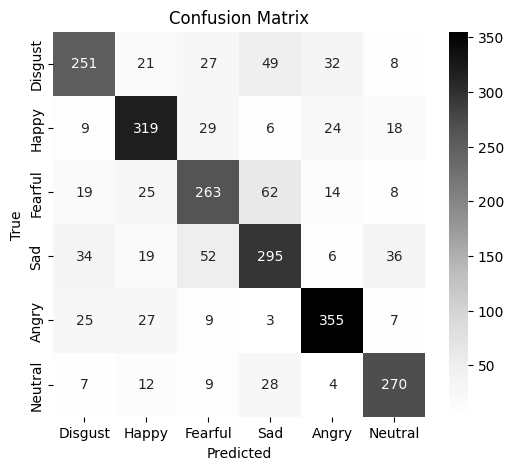

In [16]:
# ==========================
# Confusion matrix & Classification report
# ==========================
preds = trainer.predict(final_dataset["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greys",
    xticklabels=[id2label[i] for i in range(len(id2label))],
    yticklabels=[id2label[i] for i in range(len(id2label))]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

What we see here is an acceptable model that performs accordingly in all classes, with deviation when having to deal with emotions with a similar intensity, as it is the case with 'Fearful' and 'Sad'. For a more detailed analysis, I suggest reading the memoir of the project.